# Data Wrangling for [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)

https://medium.com/analytics-vidhya/machine-learning-to-predict-taxi-fare-part-one-exploratory-analysis-6b7e6b1fbc78

---

## Hypothesis Generation

To solve any analytics problems, list down a set of hypothesis. In this case, they are factors that will affect the cost of a taxi trip:

- Trip distance affects the price;
- Traffic hours might affect the price;
- Number of drivers available might affect the price;
- Weekdays VS weekends, affects the price;
- Late night hours might affect the price;
- Certain pickup or drop-off locations might affect the price;

## 1. Load Datasets

In [1]:
import math
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import subprocess
import seaborn as sns
sns.set()

# LARGE CSV LOAD and FAST: https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows
# def file_len(fname):
#     p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     result, err = p.communicate()
#     if p.returncode != 0:
#         raise IOError(err)
#     return int(result.strip().split()[0])+1

# train_rows = file_len('data/train.csv')  # 55423857
train_rows = 55423857
print (f'>>> Exact number of rows: {train_rows}')

>>> Exact number of rows: 55423857


In [2]:
test_df = pd.read_csv('data/test.csv')
submission_df = pd.read_csv('data/sample_submission.csv')

try:
    train_df = pd.read_csv('data/train.csv', nrows=round(train_rows*0.10)) # loads only 10% of the data
except FileNotFoundError:
    print('>>> You must download train.csv from: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/download/train.csv')

In [3]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5542386 entries, 0 to 5542385
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.1 GB


In [4]:
print('\n>>> train_df shape', train_df.shape)
display(train_df.head())


>>> train_df shape (5542386, 8)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
print('\n>>> test_df shape', test_df.shape)
display(test_df.head())


>>> test_df shape (9914, 7)


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [6]:
print('\n>>> submission_df shape', submission_df.shape)
display(submission_df.head())


>>> submission_df shape (9914, 2)


,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


## 2. Data Cleaning

In [7]:
# Check missing data
print(train_df.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    36
dropoff_latitude     36
passenger_count       0
dtype: int64


In [8]:
# Checks numeric columns for negative numbers
def check_numeric(df):     
    neg_count_df = pd.DataFrame(columns=['Negative values count'])
    
    #print('>>> Number of negative values found in numeric columns:')
    num_col_list = list(df.select_dtypes(include=['int64', 'float64']).columns)    
    
    total_neg = 0
    for col_name in num_col_list:
        neg_count = df[df[col_name] < 0].shape[0]  # extract number of rows        
        #print('\t*' + col_name+ '* = ' + str(neg_count))
        neg_count_df.loc[col_name] = neg_count
        total_neg += neg_count
    
    return neg_count_df, total_neg


# count how many negative values are there
neg_count_df, total_neg_count = check_numeric(train_df)
display(neg_count_df)

,Negative values count
fare_amount,236
pickup_longitude,5433997
pickup_latitude,2896
dropoff_longitude,5434109
dropoff_latitude,2913
passenger_count,0


In [9]:
# Remove NaNs and Negative & Free fares (keeping only the ones that cost more than 0)
train_df.dropna(inplace=True, axis=0)
train_df = train_df[train_df['fare_amount'] > 0]

# Cast pickup_datetime to type Datetime
# train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

In [10]:
# Remove lat/long as ZERO
print('>>> Original shape:  ', train_df.shape)
print('>>> Zero as lat/long:', train_df[(train_df.pickup_latitude==0) | (train_df.pickup_longitude)==0 | (train_df.dropoff_latitude==0)|(train_df.dropoff_longitude==0)].shape)

train_df = train_df[(train_df['pickup_latitude'] != 0) & (train_df['pickup_longitude'] != 0)]
train_df = train_df[(train_df['dropoff_latitude'] != 0) & (train_df['dropoff_longitude'] != 0)]
print('>>> After:           ', train_df.shape)

>>> Original shape:   (5541968, 8)
>>> Zero as lat/long: (105468, 8)
>>> After:            (5431600, 8)


In [11]:
# Remove fares with too many passengers
print(train_df.loc[(train_df.passenger_count <= 0) | (train_df.passenger_count > 15)].shape)
display(train_df.loc[(train_df.passenger_count <= 0) | (train_df.passenger_count > 15)].head())

train_df = train_df[(train_df['passenger_count'] > 0) & (train_df['passenger_count'] <= 15)]

(19124, 8)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
314,2015-06-02 23:16:15.00000012,34.0,2015-06-02 23:16:15 UTC,-73.974899,40.751095,-73.908546,40.881878,0
566,2012-01-28 21:33:18.0000002,4.9,2012-01-28 21:33:18 UTC,-73.955322,40.782840,-73.955797,40.773673,0
678,2012-02-27 07:24:20.0000003,6.5,2012-02-27 07:24:20 UTC,-73.983397,40.738183,-73.971395,40.758023,0
1160,2011-05-25 23:58:48.0000001,13.3,2011-05-25 23:58:48 UTC,-73.998360,40.740348,-73.946455,40.777348,0
1935,2011-10-23 11:09:28.0000001,10.1,2011-10-23 11:09:28 UTC,-73.971400,40.795000,-73.967900,40.768600,0


In [12]:
print(train_df.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5412476 entries, 0 to 5542385
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.1 GB
None


## 3. Preliminary EDA

### Distribution of fare amount

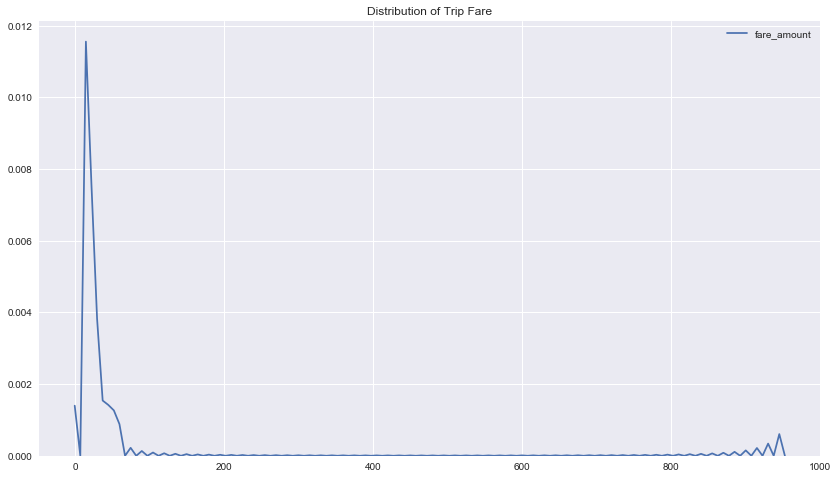

In [13]:
plt.figure(figsize=(14,8))
sns.kdeplot(train_df['fare_amount']).set_title("Distribution of Trip Fare")
plt.show()

Since we saw above that fare amount is highly skewed,let us take log transformation of the fare amount and plot the distribution:

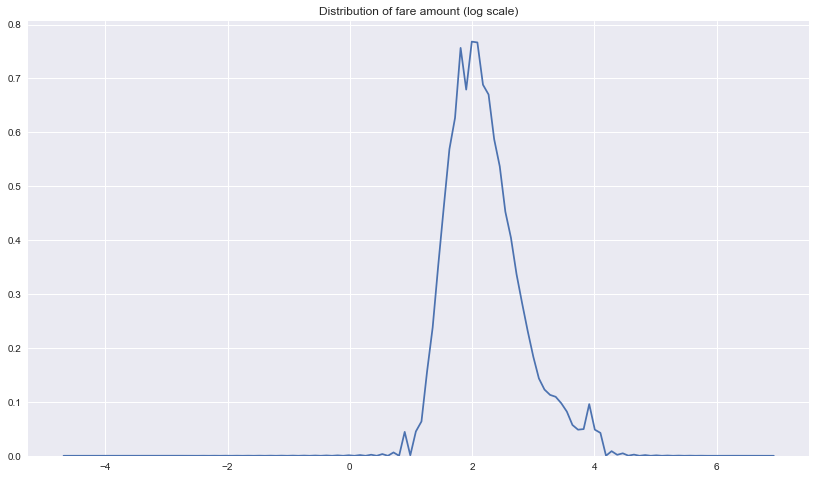

In [14]:
plt.figure(figsize=(14,8))
sns.kdeplot(np.log(train_df['fare_amount'].values)).set_title("Distribution of fare amount (log scale)")
plt.show()

### Distribution of Geographical Features

In [15]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

In [16]:
# plt.figure(figsize=(14,8))
# train_df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', color='green', s=.02, alpha=.6, ax=plt.gca())
# plt.title("Pickup Locations")
# plt.ylim(city_lat_border)
# plt.xlim(city_long_border)
# plt.show()

In [17]:
# plt.figure(figsize=(14,8))
# train_df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', color='red', s=.02, alpha=.6, ax=plt.gca())
# plt.title("Drop-off Locations")
# plt.ylim(city_lat_border)
# plt.xlim(city_long_border)
# plt.show()

### Distribution of passenger count

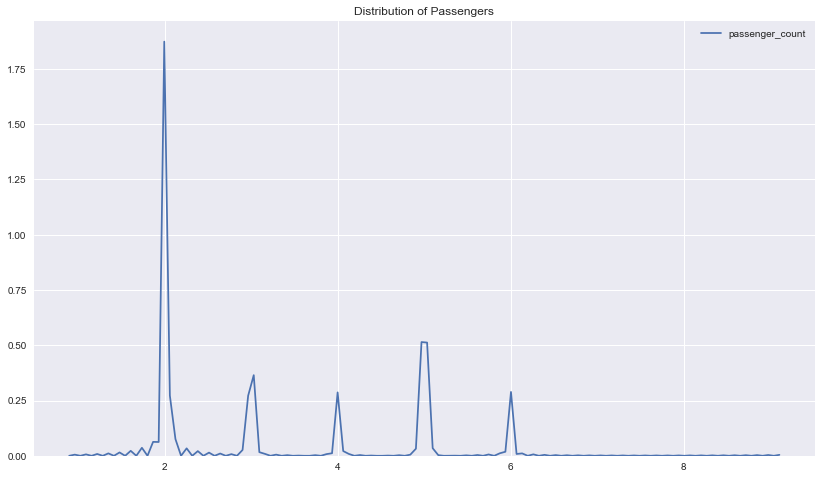

In [18]:
plt.figure(figsize=(14,8))
sns.kdeplot(train_df['passenger_count']).set_title("Distribution of Passengers")
plt.show()

# 4. Feature Engineering


In [19]:
# Distance formula: https://www.movable-type.co.uk/scripts/latlong.html
def getDistance(lat1, lon1, lat2, lon2): 
    R = 6371e3
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    deltaPhi = math.radians(lat2-lat1)
    deltaLambda = math.radians(lon2-lon1)

    a = math.sin(deltaPhi/2) * math.sin(deltaPhi/2) + math.cos(phi1) * math.cos(phi2) * math.sin(deltaLambda/2) * math.sin(deltaLambda/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return round((R * c) / 1000, 3)    # returns distance in km


# lat1 = -73.844311 
# lon1 = 40.721319
# lat2 = -73.841610
# lon2 = 40.712278    
# print(round(getDistance(lat1, lon1, lat2, lon2), 2), 'm')   #0.4104 km 

In [20]:
train_df['year'] = train_df.pickup_datetime.apply(lambda x: x[:4])
train_df['month'] = train_df.pickup_datetime.apply(lambda x: x[5:7])
train_df['day'] = train_df.pickup_datetime.apply(lambda x: x[8:10])
train_df['hour'] = train_df.pickup_datetime.apply(lambda x: x[11:13])

train_df['year'] = train_df['year'].astype('int')
train_df['month'] = train_df['month'].astype('int')
train_df['day'] = train_df['day'].astype('int')
train_df['hour'] = train_df['hour'].astype('int')

In [21]:
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')
train_df['day_of_week'] = train_df.pickup_datetime.apply(lambda x: x.weekday())

In [22]:
train_df['distance_km'] = train_df.apply(lambda row: getDistance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
print(train_df[train_df['distance_km'] < 0].shape)

(0, 14)


In [23]:
from pandas.tseries.holiday import USFederalHolidayCalendar

holidays = USFederalHolidayCalendar().holidays(start='2009-01-01', end='2015-12-31').to_pydatetime()
train_df['holiday'] = train_df.pickup_datetime.apply(lambda x: 1 if x in holidays else 0)

In [24]:
display(train_df.head())
train_df.info(memory_usage='deep')

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,distance_km,holiday
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,1.031,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,8.450,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3,1.390,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5,2.799,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1,1.999,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5412476 entries, 0 to 5542385
Data columns (total 15 columns):
key                  object
fare_amount          float64
pickup_datetime      datetime64[ns]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
year                 int32
month                int32
day                  int32
hour                 int32
day_of_week          int64
distance_km          float64
holiday              int64
dtypes: datetime64[ns](1), float64(6), int32(4), int64(3), object(1)
memory usage: 973.9 MB


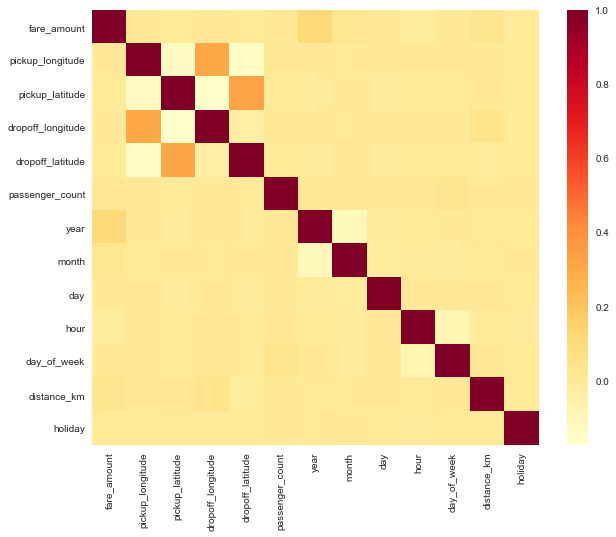

In [25]:
plt.figure(figsize=(10,8))

ax = sns.heatmap(train_df.corr(), square=True, cmap='YlOrRd')
ax.set_aspect('auto')

plt.show()

# EDA

* Hypothesis: Trip distance affects the price

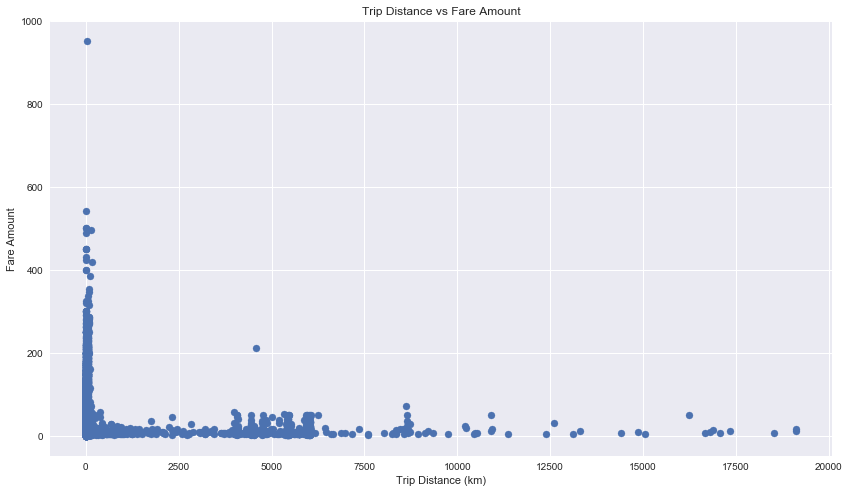

In [26]:
plt.figure(figsize=(14,8))

plt.scatter(x=train_df['distance_km'], y=train_df['fare_amount'])
plt.xlabel("Trip Distance (km)")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")
plt.show()

# 5. Model Training

In [27]:
target = train_df[['fare_amount']]
key = train_df[['key']]
pickup_datetime = train_df[['pickup_datetime']]

df = train_df.drop(['fare_amount', 'key', 'pickup_datetime'], axis=1)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_regression, RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from itertools import compress

X = df
y = target.values.ravel()

# Split X,y into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('>>> Train/Test Split done!')

# Create the 1st model using GradientBoostingRegressor
# gbr_model = GradientBoostingRegressor(n_estimators=200, random_state=7, learning_rate=0.1, max_depth=7) # with log1p/expm1: 0.514
# gbr_model.fit(X_train, np.log1p(y_train))
# print('>>> Model1 Training done!')

# Create the 2nd model using RandomForestRegressor
# rfr_model = RandomForestRegressor(n_jobs=6, bootstrap=True, max_depth=25, max_features='log2', min_samples_leaf=4, min_samples_split=5, n_estimators=25) # with log1p/expm1: 0.517
rfr_model = RandomForestRegressor(n_jobs=6, n_estimators=25, max_features='log2', max_depth=25, min_samples_split=3, min_samples_leaf=2, random_state=0)
rfr_model.fit(X_train, np.log1p(y_train))

print('>>> Model2 Training done!')

>>> Train/Test Split done!
>>> Model2 Training done!


# 6. Model Evaluation


>>> RMSE Score: 3.9440264797690996 



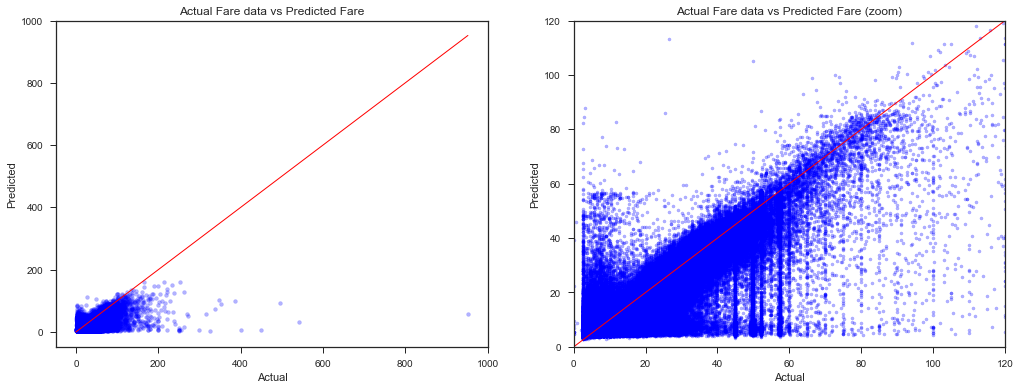

In [30]:
from lib import gfx  # gfx is another local module under the 'lib' directory
from sklearn import metrics
from math import sqrt

# The prediction is calculated as the arithmetic mean of both model's predictions
# gbr_fare = np.expm1(gbr_model.predict(X_test))  # model 1
rfr_fare = np.expm1(rfr_model.predict(X_test))   # model 2

# y_pred = (gbr_visitors + rfr_visitors) / 2
y_pred = rfr_fare

rmse_score = sqrt(metrics.mean_squared_error(y_test, y_pred))
print('\n>>> RMSE Score:', rmse_score, '\n') # 3.955

# Plot Actual FARE data against Predicted fare
gfx.plot_actual_vs_predicted(y, y_test, y_pred)